In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import numpy as np
import os



c:\Users\Abhishek Ramola\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim.lr_scheduler as lr_scheduler

import random
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import BertModel, BertTokenizer

import torch

from PIL import Image
import pandas as pd

In [3]:
class BERTResNetClassifier(nn.Module):
    def __init__(self, num_classes=6):

        super(BERTResNetClassifier, self).__init__()

        self.num_classes = num_classes

        # Image processing (ResNet)
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Image processing (Fully Connected Layer)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

        # Dropout layer
        self.drop = nn.Dropout(p=0.3)

        # Text processing (using the 768-dimensional BERT arrays)
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Text processing (Fully Connected Layer)
        self.fc_text = nn.Linear(in_features=self.text_model.config.hidden_size, out_features=num_classes, bias=True)

        # Fusion and classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image, text_input_ids, text_attention_mask,):
        # Image branch
        x_img = self.image_model(image)
        x_img = self.drop(x_img)
        x_img = self.fc_image(x_img)

        # Text branch
        x_text_last_hidden_states = self.text_model(
            input_ids = text_input_ids,
            attention_mask = text_attention_mask,
            return_dict=False
        )
        x_text_pooled_output = x_text_last_hidden_states[0][:, 0, :]
        x_text = self.drop(x_text_pooled_output)
        x_text = self.fc_text(x_text_pooled_output)

        # Fusion and max merge
        x = torch.max(x_text, x_img)

        # Classification
        #x = self.softmax(x) #-> already applied in crossentropy loss

        return x

In [4]:
# ==== Update this with your actual label map ====
label_map = {
    0: "True Content",
    1: "Satire / Parody",
    2: "False Connection",
    3: "Imposter Content",
    4: "Manipulated Content",
    5: "Misleading Content"
}
inv_label_map = {v: k for k, v in label_map.items()}



In [5]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_dir="images", max_len=64):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_dir = image_dir
        self.supported_exts = [".jpg", ".jpeg", ".png"]

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    def _resolve_image_path(self, image_id):
        for ext in self.supported_exts:
            image_path = os.path.join(self.image_dir, f"{image_id}{ext}")
            if os.path.isfile(image_path):
                return image_path
        raise FileNotFoundError(f"No image found for ID: {image_id}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row["clean_title"]
        image_id = row["id"]
        label = row["6_way_label"]  # numeric label (0–5)

        encoding = self.tokenizer(text, padding='max_length', truncation=True,
                                  max_length=self.max_len, return_tensors="pt")
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        image_path = self._resolve_image_path(image_id)
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        return image, input_ids, attention_mask, label

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in dataloader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(images, input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


c:\Users\Abhishek Ramola\.conda\envs\torch\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 


Classification Report:
                     precision    recall  f1-score   support

       True Content       0.93      0.92      0.92      2567
    Satire / Parody       0.81      0.79      0.80       258
   False Connection       0.83      0.87      0.85       866
   Imposter Content       0.90      0.65      0.75       110
Manipulated Content       0.94      0.96      0.95      1302
 Misleading Content       0.89      0.86      0.88       189

           accuracy                           0.91      5292
          macro avg       0.88      0.84      0.86      5292
       weighted avg       0.91      0.91      0.91      5292


Accuracy: 0.9061


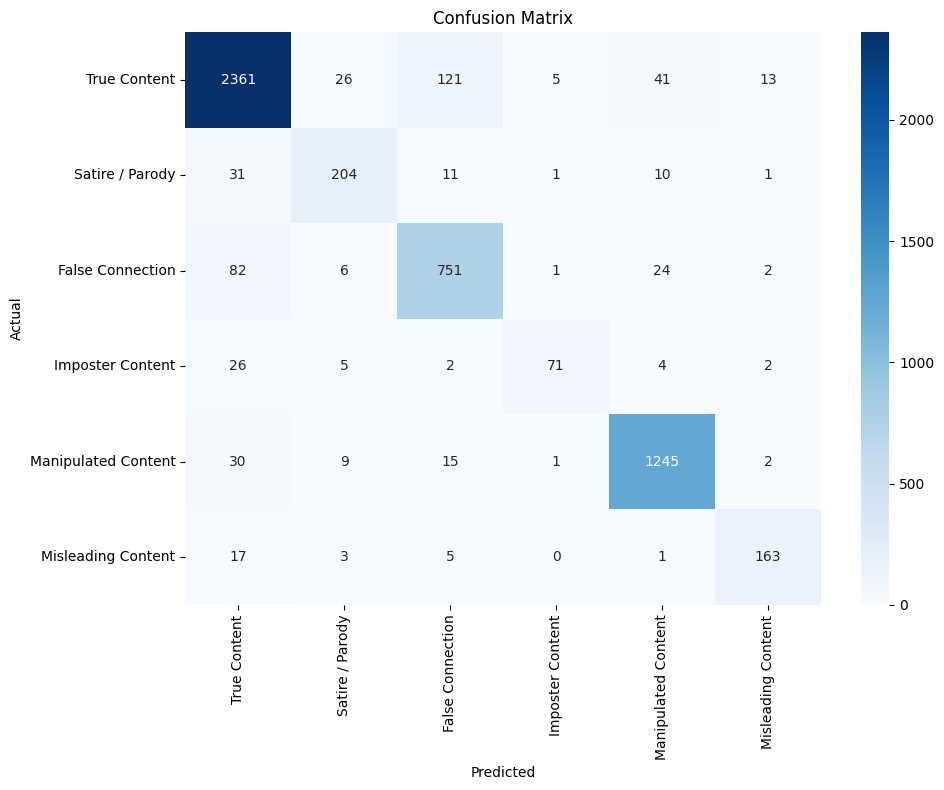

In [8]:
# ===================
# Main
# ===================
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = BERTResNetClassifier(num_classes=6)
model.load_state_dict(torch.load("./models/model_epoch_32.pth", map_location=device), strict=False)
model.to(device)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load and filter DataFrame
df = pd.read_csv("./data/test_cleaned2.csv")
existing_images = set(os.path.splitext(f)[0] for f in os.listdir("images") if f.endswith((".jpg", ".jpeg", ".png")))
df = df[df["id"].isin(existing_images)].reset_index(drop=True)

# Create DataLoader
dataset = MultimodalDataset(df, tokenizer, image_dir="images")
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

# Evaluate
preds, labels = evaluate_model(model, dataloader)

# Metrics
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=label_map.values()))

acc = accuracy_score(labels, preds)
print(f"\nAccuracy: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()